# Artificial Intelligence Nanodegree
## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

In [2]:
import collections

import helper
import numpy as np
import project_tests as tests

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.models import Sequential


Using TensorFlow backend.


### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14755164883800141478
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 357302272
locality {
  bus_id: 1
}
incarnation: 9647717029255385648
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [4]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


In [6]:
english_sentences[0:5]

['new jersey is sometimes quiet during autumn , and it is snowy in april .',
 'the united states is usually chilly during july , and it is usually freezing in november .',
 'california is usually quiet during march , and it is usually hot in june .',
 'the united states is sometimes mild during june , and it is cold in september .',
 'your least liked fruit is the grape , but my least liked is the apple .']

In [7]:
french_sentences[0:5]

["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .",
 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .',
 'california est généralement calme en mars , et il est généralement chaud en juin .',
 'les états-unis est parfois légère en juin , et il fait froid en septembre .',
 'votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .']

In [10]:
#https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [8]:
for sample_i in range(5):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
small_vocab_en Line 3:  california is usually quiet during march , and it is usually hot in june .
small_vocab_fr Line 3:  california est généralement calme en mars , et il est généralement chaud en juin .
small_vocab_en Line 4:  the united states is sometimes mild during june , and it is cold in september .
small_vocab_fr Line 4:  les états-unis est parfois légère en juin , et il fait froid en septembre .
small_vocab_en Line 5:  your least liked fruit is the grape , but my least liked is the apple .
small_vocab_fr Line 5:  votre moins aimé fruit est le raisin , m

From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [9]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [13]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    # TODO: Implement
    x_tk = Tokenizer(char_level=False)
    x_tk.fit_on_texts(x)

    return x_tk.texts_to_sequences(x), x_tk
    #return None, None
tests.test_tokenize(tokenize)

# Tokenize Example output
#text_sentences = [
    #'The quick brown fox jumps over the lazy dog .',
    #'By Jove , my quick study of lexicography won a prize .',
    #'This is a short sentence .']
text_sentences = english_sentences[0:5]
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'is': 1, 'during': 2, 'and': 3, 'it': 4, 'in': 5, 'the': 6, 'usually': 7, 'sometimes': 8, 'quiet': 9, 'united': 10, 'states': 11, 'june': 12, 'least': 13, 'liked': 14, 'new': 15, 'jersey': 16, 'autumn': 17, 'snowy': 18, 'april': 19, 'chilly': 20, 'july': 21, 'freezing': 22, 'november': 23, 'california': 24, 'march': 25, 'hot': 26, 'mild': 27, 'cold': 28, 'september': 29, 'your': 30, 'fruit': 31, 'grape': 32, 'but': 33, 'my': 34, 'apple': 35}

Sequence 1 in x
  Input:  new jersey is sometimes quiet during autumn , and it is snowy in april .
  Output: [15, 16, 1, 8, 9, 2, 17, 3, 4, 1, 18, 5, 19]
Sequence 2 in x
  Input:  the united states is usually chilly during july , and it is usually freezing in november .
  Output: [6, 10, 11, 1, 7, 20, 2, 21, 3, 4, 1, 7, 22, 5, 23]
Sequence 3 in x
  Input:  california is usually quiet during march , and it is usually hot in june .
  Output: [24, 1, 7, 9, 2, 25, 3, 4, 1, 7, 26, 5, 12]
Sequence 4 in x
  Input:  the united states is sometimes mild du

### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [14]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen=length, padding='post')
    #return None
tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [15 16  1  8  9  2 17  3  4  1 18  5 19]
  Output: [15 16  1  8  9  2 17  3  4  1 18  5 19  0  0]
Sequence 2 in x
  Input:  [ 6 10 11  1  7 20  2 21  3  4  1  7 22  5 23]
  Output: [ 6 10 11  1  7 20  2 21  3  4  1  7 22  5 23]
Sequence 3 in x
  Input:  [24  1  7  9  2 25  3  4  1  7 26  5 12]
  Output: [24  1  7  9  2 25  3  4  1  7 26  5 12  0  0]
Sequence 4 in x
  Input:  [ 6 10 11  1  8 27  2 12  3  4  1 28  5 29]
  Output: [ 6 10 11  1  8 27  2 12  3  4  1 28  5 29  0]
Sequence 5 in x
  Input:  [30 13 14 31  1  6 32 33 34 13 14  1  6 35]
  Output: [30 13 14 31  1  6 32 33 34 13 14  1  6 35  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [15]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


In [16]:
preproc_english_sentences

array([[17, 23,  1, ..., 44,  0,  0],
       [ 5, 20, 21, ..., 51,  2, 45],
       [22,  1,  9, ..., 34,  0,  0],
       ..., 
       [24,  1, 10, ..., 54,  0,  0],
       [ 5, 84,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [17]:
preproc_french_sentences[:,0,0]

array([ 35,   4, 101, ...,   7,  84,   0], dtype=int32)

## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [12]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [13]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    #Functional API (same as example in the lecture notes)
    learning_rate = 1e-3

    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences=True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.summary()
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.00001,patience = 5, mode='auto'),
             ModelCheckpoint(filepath='simple_model.h5', monitor='val_acc', save_best_only=True)]
history = simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=128,callbacks=callbacks, epochs=30, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))
#print score
score = simple_rnn_model.evaluate(tmp_x, preproc_french_sentences, verbose=0)
print("Train accuracy: ", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 64)            12672     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 344)           22360     
_________________________________________________________________
activation_1 (Activation)    (None, 21, 344)           0         
Total params: 35,032
Trainable params: 35,032
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
gru_2 

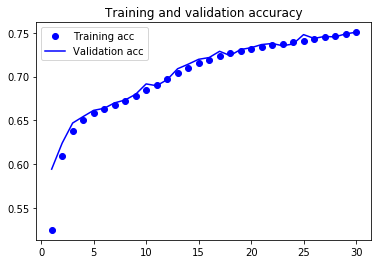

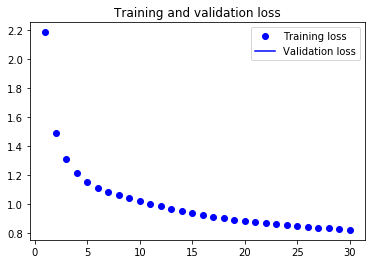

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 2: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [15]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 1e-3
    model = Sequential()
    model.add(Embedding(max(english_vocab_size, french_vocab_size) ,128 , input_length=output_sequence_length))   
    model.add(GRU(128, dropout=0.1,recurrent_dropout = 0.5, return_sequences=True))
    model.add(GRU(64, dropout=0.1,recurrent_dropout = 0.5, return_sequences=True))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(french_vocab_size, activation='softmax'))
    
    model.summary()
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model
tests.test_embed_model(embed_model)


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.00001,patience = 5, mode='auto'),
             ModelCheckpoint(filepath='embed_model.h5', monitor='val_acc', save_best_only=True)]
history = embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=128,callbacks=callbacks, epochs=30, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

#print score
score = embed_rnn_model.evaluate(tmp_x, preproc_french_sentences, verbose=0)
print("Train accuracy: ", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 128)           44032     
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 128)           98688     
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 64)            37056     
_________________________________________________________________
dense_3 (Dense)              (None, 21, 32)            2080      
_________________________________________________________________
dense_4 (Dense)              (None, 21, 344)           11352     
Total params: 193,208
Trainable params: 193,208
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embe

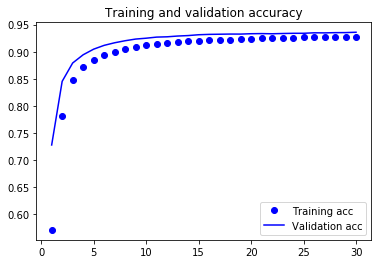

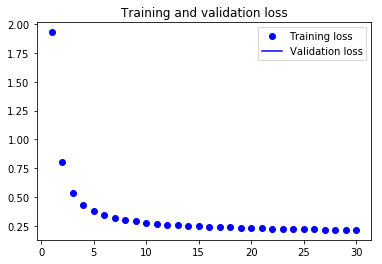

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [17]:

def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    #print("shape: ", input_shape[1:])
    learning_rate = 1e-3
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.1),
                        input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(64,activation ='relu', dropout=0.1,recurrent_dropout = 0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(128,activation = 'relu', dropout=0.1, return_sequences=True)))
    model.add(Dense(32, activation='relu'))    
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax') ))
    
    
    model.summary()
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model
    
tests.test_bd_model(bd_model)


# TODO: Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# TODO: Train and Print prediction(s)
bd_rnn_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.00001,patience = 5, mode='auto'),
             ModelCheckpoint(filepath='bd_rnn_model.h5', monitor='val_acc', save_best_only=True)]
history = bd_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=128,callbacks = callbacks, epochs=30, validation_split=0.2)
# Print prediction(s)
print(logits_to_text(bd_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))
#print score
score = bd_rnn_model.evaluate(tmp_x, preproc_french_sentences, verbose=0)
print("Train accuracy: ", score[1])

# TODO: Train and Print prediction(s)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 21, 256)           99840     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 128)           123264    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 256)           263168    
_________________________________________________________________
dense_7 (Dense)              (None, 21, 32)            8224      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 344)           11352     
Total params: 505,848
Trainable params: 505,848
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidi

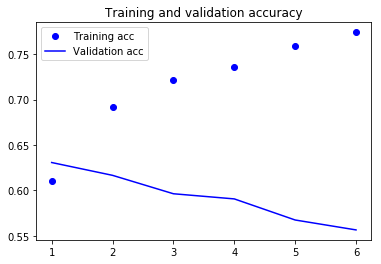

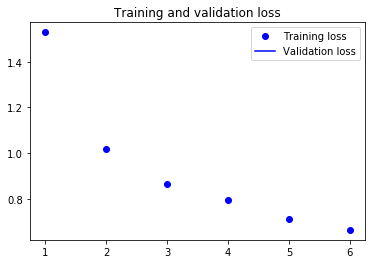

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [19]:


def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 1e-3
    model = Sequential()
    #print(output_sequence_length)
    #encoder
    model.add(GRU(128, input_shape=input_shape[1:], return_sequences=False, dropout=0.1,recurrent_dropout = 0.5) )
    model.add(RepeatVector(output_sequence_length))    
    #decoder
    model.add(GRU(128, return_sequences=True, dropout=0.1,recurrent_dropout = 0.5) )    
    model.add(TimeDistributed(Dense(256, activation='tanh')))   
    #output
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax') ))
       
    model.summary()
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model 

tests.test_encdec_model(encdec_model)


# OPTIONAL: Train and Print prediction(s)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences)
tmp_x = tmp_x.reshape((-1, preproc_english_sentences.shape[1], 1))

print("input shape: ", tmp_x.shape)

# Train the neural network
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.00001,patience = 5, mode='auto'),
             ModelCheckpoint(filepath='encdec_rnn_model.h5', monitor='val_acc', save_best_only=True)]

history = encdec_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=128,callbacks = callbacks, epochs=30, validation_split=0.2)
# Print prediction(s)
print(logits_to_text(encdec_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))                    
#print score
score = encdec_rnn_model.evaluate(tmp_x, preproc_french_sentences, verbose=0)
print("Train accuracy: ", score[1])

# OPTIONAL: Train and Print prediction(s)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 128)               49920     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 128)           0         
_________________________________________________________________
gru_12 (GRU)                 (None, 21, 128)           98688     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 21, 256)           33024     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 21, 344)           88408     
Total params: 270,040
Trainable params: 270,040
Non-trainable params: 0
_________________________________________________________________
input shape:  (137861, 15, 1)
_________________________________________________________________
Layer (type)                 Output Shap

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [18]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 1e-3
    model = Sequential()
    model.add(Embedding(max(english_vocab_size, french_vocab_size) ,128 , input_length=input_shape[1]))
    #encoder
    model.add(Bidirectional(GRU(128, return_sequences=False, dropout=0.1,recurrent_dropout = 0.5),input_shape=input_shape[1:]))
    model.add(RepeatVector(output_sequence_length))
    #decoder
    model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.1,recurrent_dropout = 0.5)) )
    model.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.1,recurrent_dropout = 0.5)) )
    model.add(Dense(32, activation='relu'))
    #output
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax') ))   
    
    model.summary()
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model
tests.test_model_final(model_final)

print('Final Model Loaded')
# TODO: Train the final model
# Visualize the model
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 128)           44032     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197376    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 256)           295680    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 128)           123264    
_________________________________________________________________
dense_1 (Dense)              (None, 21, 32)            4128      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 344)           11352     
Total para

In [43]:
#! pip3 install ann_visualizer

In [44]:
#! pip3 install graphviz

In [30]:
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')

In [45]:
#from ann_visualizer.visualize import ann_viz;
#ann_viz(tests.test_model_final(model_final))

In [19]:
# Draw the model
learning_rate = 1e-3
X_input = pad(preproc_english_sentences)#try if this works.dropna()
input_shape = X_input.shape
output_sequence_length = max_french_sequence_length
model = Sequential()
model.add(Embedding(max(english_vocab_size, french_vocab_size) ,128 , input_length=input_shape[1]))
#encoder
model.add(Bidirectional(GRU(128, return_sequences=False, dropout=0.1,recurrent_dropout = 0.5),input_shape=input_shape[1:]))
model.add(RepeatVector(output_sequence_length))
#decoder
model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.1,recurrent_dropout = 0.5)) )
model.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.1,recurrent_dropout = 0.5)) )
model.add(Dense(32, activation='relu'))
#output
model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax') ))  

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#from ann_visualizer.visualize import ann_viz;
# #Build your model here
#ann_viz(model)

In [46]:
#! pip install keras-vis

In [ ]:
# https://github.com/raghakot/keras-vis
# https://github.com/PaddlePaddle/VisualDL
# https://towardsdatascience.com/visualizing-artificial-neural-networks-anns-with-just-one-line-of-code-b4233607209e
# Visualization Libraries

## Prediction (IMPLEMENTATION)

In [20]:
#changed added history = fit
# epochs has been increased to 100 , removed callback for early stopping
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    # TODO: Train neural network using model_final
    X_input = pad(preproc_english_sentences)  
    model = model_final(
        X_input.shape,
        max_french_sequence_length,
        english_vocab_size,
        french_vocab_size)
    # Set callback functions to early stop training and save the best model so far
    #callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.0001,patience = 5, mode='auto'),
             #ModelCheckpoint(filepath='final_model.h5', monitor='val_acc', save_best_only=True)]
    #increase to later
    history = model.fit(X_input, preproc_french_sentences, batch_size=128, epochs=3, validation_split=0.2)
    
    
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15, 128)           44032     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               197376    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 21, 256)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 21, 256)           295680    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 21, 128)           123264    
_________________________________________________________________
dense_5 (Dense)              (None, 21, 32)            4128      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 344)           11352     
Total para

#### for plotting the history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 15, 128)           44032     
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 256)               197376    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 21, 256)           0         
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 21, 256)           295680    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 21, 128)           123264    
_________________________________________________________________
dense_19 (Dense)             (None, 21, 32)            4128      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 21, 344)           11352     
Total para

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 15, 128)           44032     
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 256)               197376    
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 21, 256)           0         
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 21, 256)           295680    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 21, 128)           123264    
_________________________________________________________________
dense_21 (Dense)             (None, 21, 32)            4128      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 21, 344)           11352     
Total para

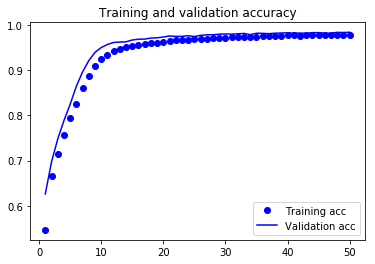

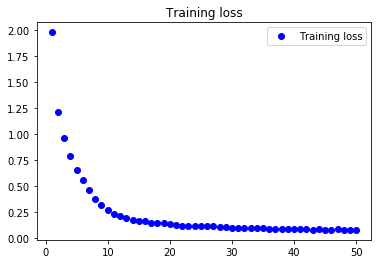

In [ ]:
learning_rate = 1e-3
model = Sequential()
model.add(Embedding(max(english_vocab_size, french_vocab_size) ,128 , input_length=input_shape[1]))
#encoder
model.add(Bidirectional(GRU(128, return_sequences=False, dropout=0.1,recurrent_dropout = 0.5),input_shape=input_shape[1:]))
model.add(RepeatVector(output_sequence_length))
#decoder
model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.1,recurrent_dropout = 0.5)) )
model.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.1,recurrent_dropout = 0.5)) )
model.add(Dense(32, activation='relu'))
#output
model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax') ))   
    
model.summary()
    
model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
history = model.fit(X_input, preproc_french_sentences, batch_size=128, epochs=50, validation_split=0.2)
X_input = pad(preproc_english_sentences)  
model = model_final(
        X_input.shape,
        max_french_sequence_length,
        english_vocab_size,
        french_vocab_size)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

## Submission
When you're ready to submit, complete the following steps:
1. Review the [rubric](https://review.udacity.com/#!/rubrics/1004/view) to ensure your submission meets all requirements to pass
2. Generate an HTML version of this notebook

  - Run the next cell to attempt automatic generation (this is the recommended method in Workspaces)
  - Navigate to **FILE -> Download as -> HTML (.html)**
  - Manually generate a copy using `nbconvert` from your shell terminal
```
$ pip install nbconvert
$ python -m nbconvert machine_translation.ipynb
```
  
3. Submit the project

  - If you are in a Workspace, simply click the "Submit Project" button (bottom towards the right)
  
  - Otherwise, add the following files into a zip archive and submit them 
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.

### Generate the html

**Save your notebook before running the next cell to generate the HTML output.** Then submit your project.

In [22]:
# Save before you run this cell!
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook machine_translation.ipynb to html',
 '[NbConvertApp] Writing 468387 bytes to machine_translation.html']

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?

In [ ]:
# fixed random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
cross_val_scores=[]
for train_index, test_index in kfold.split(preproc_english_sentences,preproc_french_sentences[:,0,0]):
   
    model = model_final(preproc_english_sentences[train_index].shape,
                        max_french_sequence_length,
                        english_vocab_size,
                        french_vocab_size)
    # fit the model 50 epochs
    model.fit(preproc_english_sentences[train_index], preproc_french_sentences[train_index],
              batch_size=128, epochs=50, verbose=0)
    # evaluate the model
    scores = model.evaluate(preproc_english_sentences[test_index], preproc_french_sentences[test_index], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cross_val_scores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_scores), np.std(cross_val_scores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 15, 128)           44032     
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 256)               197376    
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 21, 256)           0         
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 21, 256)           295680    
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 21, 128)           123264    
_________________________________________________________________
dense_23 (Dense)             (None, 21, 32)            4128      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 21, 344)           11352     
Total para

References:
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/